# 利用SVM、决策树、随机森林和KNN对信用卡违约率进行分析



## 数据来源及字段含义
python已被广泛应用在数据分析领域，这回我们就用几种常见的分类算法对信用卡违约进行识别，来帮助我们更好的完成风控措施。    

本次分析的数据来源:https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

该数据是某银行从2005年4月至9月的信用卡数据，数据包含25个字段，具体含义如下：    

| 字段 | 含义 |   
| :---: | :-----: |    
| ID | 客户ID |
| LIMIT_BAL | 可透支金额 |
| SEX | 性别（1=男，2=女） |
| EDUCATION | 1=研究生, 2=本科, 3=高中, 4=others, 5=未知, 6=未知 |
| MARRIGE | 婚姻状况 (1=已婚, 2=单身, 3=其它) |
| AGE | 年龄 |
| PAY_0 | 2005年9月还款状况 |
| PAY_2 | 2005年8月还款状况 |
| PAY_3 | 2005年7月还款状况 |
| PAY_4 | 2005年6月还款状况 |
| PAY_5 | 2005年5月还款状况 |
| PAY_6 | 2005年4月还款状况 |
| BILL_AMT1 | 2005年9月账单金额 |
| BILL_AMT2 | 2005年8月账单金额 |
| BILL_AMT3 | 2005年7月账单金额 |
| BILL_AMT4 | 2005年6月账单金额 |
| BILL_AMT5 | 2005年5月账单金额 |
| BILL_AMT6 | 2005年4月账单金额 |
| PAY_AMT1 | 2005年9月还款金额 |
| PAY_AMT2 | 2005年8月还款金额 |
| PAY_AMT3 | 2005年7月还款金额 |
| PAY_AMT4 | 2005年6月还款金额 |
| PAY_AMT5 | 2005年5月还款金额 |
| PAY_AMT6 | 2005年4月还款金额 |
| default.payment.next.month | 下月违约情况（1：违约，0：守约） |

## 数据描述性统计分析
python中有相当便捷的库可以让我们了解一些数据的基本信息何进行可视化如pandas/seaborn/matplotlib等，接下来我们利用这些库进行描述性统计分析。

(30000, 25)
                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904  

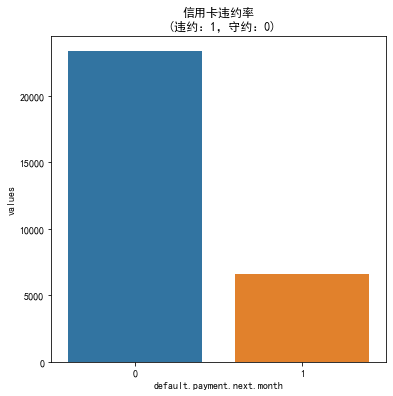

In [2]:
%matplotlib inline  #添加这行代码，否则图表画不出来
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
data=pd.read_csv(r".\UCI_Credit_Card.csv")
print(data.shape)
print(data.describe())
next_month=data['default.payment.next.month'].value_counts()
print(next_month)
df=pd.DataFrame({'default.payment.next.month':next_month.index,'values':next_month.values})
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(6,6))
plt.title('信用卡违约率\n (违约：1，守约：0)')
sns.set_color_codes('pastel')
sns.barplot(x='default.payment.next.month',y='values',data=df)
locs,labels=plt.xticks()
plt.show()

通过初步观察我们发现每个字段都没有空值，所以无需对空值进行处理。但是我们发现了一些异常值，比如BILL_AMT等字段竟然有负值，这不符合实际情况，你的账单上不会有负值出现。并且结合对csv表的观察，我们还发现BILL_AMT和PAY_AMT字段竟然存在全为0的情况，这说明这行数据对我们分析毫无作用，无借款无还款说明不存在违约不违约这一说法，针对这些数据应给予删除。

## 数据清洗

In [4]:
data1=data[(data['BILL_AMT1']>=0) & (data['BILL_AMT2']>=0) & (data['BILL_AMT3']>=0 )& (data['BILL_AMT4']>=0) & (data['BILL_AMT5']>=0) & (data['BILL_AMT6']>=0)]
#去除负值行
data2=data1[(data1['BILL_AMT1']!=0) & (data1['BILL_AMT2']!=0) & (data1['BILL_AMT3']!=0 )& (data1['BILL_AMT4']!=0) & (data1['BILL_AMT5']!=0) & (data1['BILL_AMT6']!=0)]
#去除值全为0的行
print(data2.shape)
data2.drop(['ID'],inplace=True,axis=1)  #ID对我们进行数据分析无用，所以删去
target=data2['default.payment.next.month'].values  #结果集
columns=data2.columns.tolist()
columns.remove('default.payment.next.month')
features=data2[columns].values   #特征值

(22384, 25)


C:\Users\Brown\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 模型搭建

***完整代码如下：***

In [10]:
import pandas as pd
from  sklearn.model_selection  import learning_curve , train_test_split ,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
data=pd.read_csv(r".\UCI_Credit_Card.csv")
data1=data[(data['BILL_AMT1']>=0) & (data['BILL_AMT2']>=0) & (data['BILL_AMT3']>=0 )& (data['BILL_AMT4']>=0) & (data['BILL_AMT5']>=0) & (data['BILL_AMT6']>=0)]
#去除负值行
data2=data1[(data1['BILL_AMT1']!=0) & (data1['BILL_AMT2']!=0) & (data1['BILL_AMT3']!=0 )& (data1['BILL_AMT4']!=0) & (data1['BILL_AMT5']!=0) & (data1['BILL_AMT6']!=0)]
#去除值全为0的行
print(data2.shape)
data2.drop(['ID'],inplace=True,axis=1)  #ID对我们进行数据分析无用，所以删去
target=data2['default.payment.next.month'].values  #结果集
columns=data2.columns.tolist()
columns.remove('default.payment.next.month')
features=data2[columns].values   #特征值
train_x,test_x,train_y,test_y=train_test_split(features,target,test_size=0.25,stratify=target,random_state=1)
#将25%的数据当成测试集，其余为训练集
classifiers=[SVC(random_state=1,kernel='rbf'),DecisionTreeClassifier(random_state=1,criterion='gini'),
             RandomForestClassifier(random_state=1,criterion='gini'),KNeighborsClassifier(metric='minkowski')]
classifier_names=['svc','decisiontreeclassifier','randomforestclassifier','kneighborsclassifier']
classifier_param_grid=[{'svc__C':[1],'svc__gamma':[0.01]},
                       {'decisiontreeclassifier__max_depth':[6,9,11]},
                       {'randomforestclassifier__n_estimators':[3,5,6]},
                       {'kneighborsclassifier__n_neighbors':[4,6,8]}]
#上面代码是为了进行pipeline做准备，管道机制可以将固定数据分析的固定流程封装起来，减少代码冗余
def GridSearchCV_work(pipeline,train_x,train_y,test_x,test_y,param_grid,score='accuracy'):
    response={}
    gridsearch=GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring=score)
    search=gridsearch.fit(train_x,train_y)
    print('GridSearch最优参数：',search.best_params_)
    print('GridSearch最优分数：%0.4f'%search.best_score_)
    predict_y=gridsearch.predict(test_x)
    print('准确率为%.4f'%accuracy_score(test_y,predict_y))
    return response
#GridSearchCV 能帮助我们挑选出estimators中最优参数个数，当然参数个数范围还是需要我们指定
for model,model_name,model_param_grid in zip(classifiers,classifier_names,classifier_param_grid):
    pipeline=Pipeline([('scaler',StandardScaler()),
                      (model_name,model)])
    result=GridSearchCV_work(pipeline,train_x,train_y,test_x,test_y,model_param_grid,score='accuracy')

(22384, 25)


C:\Users\Brown\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Brown\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearch最优参数： {'svc__C': 1, 'svc__gamma': 0.01}
GridSearch最优分数：0.8276
准确率为0.8261


C:\Users\Brown\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearch最优参数： {'decisiontreeclassifier__max_depth': 6}
GridSearch最优分数：0.8209
准确率为0.8193


C:\Users\Brown\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearch最优参数： {'randomforestclassifier__n_estimators': 6}
GridSearch最优分数：0.8046
准确率为0.8016


C:\Users\Brown\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearch最优参数： {'kneighborsclassifier__n_neighbors': 8}
GridSearch最优分数：0.8085
准确率为0.8029


通过GridSearchCV和Pipeline，我们便捷地使用分类器提高了效率，迅速地比较了各种分类器准确成俗，并且从上面我们能看到，在这几种算法当中SVC准确率最高达到0.8261。